In [1]:
%matplotlib inline

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import datetime

# What is required to be the best*?
### *football player in your division

## Table of Contents
[Introduction](#introdiction-link)
- [1.1 Data](#data-link)
- [1.2 Research Question](#question-link)

[Data Wrangling](#wrangling-link)
- [2.1 Loading...](#load-link)
- [2.2 Connecting Sources](#conn-link)
- [2.3 Feature Engineering](#engineer-link)

[EDA](#eda-link)

## Introduction <a class="anchor" id="introduction-link"></a>

### 1.1 Data <a class="anchor" id="data-link"></a>

#### 1.1.1 First data source is Kaggle: the [European Soccer Database](https://www.kaggle.com/datasets/hugomathien/soccer):

This soccer database comes from Kaggle and is well suited for data analysis and machine learning. It contains data for soccer  matches, players, and teams from several European countries from 2008 to 2016. The dataset has 7 tables called 'Country', 'League', 'Match', 'Player', 'Player Attributes', 'Team' and 'Team Attributes'. Attributes tables are available thanks to EA Sports' FIFA video game series. I bit a statistics taken from the database's Kaggle page:

- +25,000 matches
- +10,000 players
- 11 European Countries with their lead championship
- Seasons 2008 to 2016
- Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the weekly updates
- Team line up with squad formation (X, Y coordinates)
- Betting odds from up to 10 providers
- Detailed match events (goal types, possession, corner, cross, fouls, cards etc…) for +10,000 matches

What we will touch on in this notebook is the 'Player' and 'Player Attributes' tables. The databe is in sqlite format. I transformed the needed tables in .csv to be able to upload them together with the notebook.

#### 1.1.2 My second Data source is google. I manually collected 'player of the season' rankings for each championship in the database from Kaggle 
- The list is attached in .xlsx format.

### 1.2 Research Question <a class="anchor" id="question-link"></a>

What I would like to look into is the __common attributes of the best__. 
- Is there any relation between attributes and being the best? 
- What qualities do you need in order to be the best performer in, arguably, the most competitive Football/Soccer League in the World?
- Can we predict who might be the next player of the season based on his profile as a player? 

Altough we have data for mutiple leagues, we will turn our attention to the Premier League only. The same steps could be easily applied for the rest of the leagues available in the database.

## Data Wrangling <a class="anchor" id="wrangling-link"></a>

### 2.1 Loading... <a class="anchor" id="load-link"></a>

In [3]:
path = 'data/database.sqlite'
con = sql.connect(path)

In [4]:
best_players = pd.read_excel('data/best_players.xlsx')
player = pd.read_sql('select * from Player;', con)
player_attributes = pd.read_sql('select * from Player_Attributes;', con)

##### Let's see how the tables look:

`best_players`

In [5]:
best_players.head()

,season,name,club,champion,league
0,2008–9,Nemanja Vidic,Manchester United,1,England Premier League
1,2009–10,Wayne Rooney,Manchester United,0,England Premier League
2,2010–11,Nemanja Vidic,Manchester United,1,England Premier League
3,2011–12,Vincent Kompany,Manchester City,1,England Premier League
4,2012–13,Gareth Bale,Tottenham Hotspur,0,England Premier League


In [6]:
best_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 5 columns):
season      72 non-null object
name        72 non-null object
club        72 non-null object
champion    72 non-null int64
league      72 non-null object
dtypes: int64(1), object(4)
memory usage: 2.9+ KB


- season------72 non-null object--> What season was the player 'player of the season'?
- name--------72 non-null object--> What is the name of the player?
- club--------72 non-null object----> What club did he play at the time?
- champion----72 non-null int64--> Was his team crowned Champions at the season he won the award?
- league------72 non-null object--> Which league did he play in?

`player`

In [7]:
player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [8]:
player.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 7 columns):
id                    11060 non-null int64
player_api_id         11060 non-null int64
player_name           11060 non-null object
player_fifa_api_id    11060 non-null int64
birthday              11060 non-null object
height                11060 non-null float64
weight                11060 non-null int64
dtypes: float64(1), int64(4), object(2)
memory usage: 605.0+ KB


Let's convert the `birthday` column to datetime:

In [9]:
player.birthday = pd.to_datetime(player.birthday)

`player_attributes`

In [10]:
player_attributes.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [11]:
player_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
id                     183978 non-null int64
player_fifa_api_id     183978 non-null int64
player_api_id          183978 non-null int64
date                   183978 non-null object
overall_rating         183142 non-null float64
potential              183142 non-null float64
preferred_foot         183142 non-null object
attacking_work_rate    180748 non-null object
defensive_work_rate    183142 non-null object
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
volleys                181265 non-null float64
dribbling              183142 non-null float64
curve                  181265 non-null float64
free_kick_accuracy     183142 non-null float64
long_passing           183142 non-null float64
ball_control           183142 non-null float64
accele

In [12]:
player_attributes.date = pd.to_datetime(player_attributes.date)

### 2.2 Connecting Sources <a class="anchor" id="conn-link"></a>

##### Next, combining the two sources.
<br>First, let's start by identifying the players from our best_players list by name

In [13]:
player_best = player[player.player_name.isin(best_players.name.to_list())]

Trust me when I say that there are a couple duplicate names. So let's get rid of those

In [14]:
duplicate_players = player_best.player_name[player_best.player_name.duplicated()].to_list()
best_players[best_players.name.isin(duplicate_players)]
player_best[player_best.player_name.isin(duplicate_players)]


,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
1406,1409,25920,Bruno Alves,138110,1981-11-27,187.96,183
1407,1410,375782,Bruno Alves,210292,1990-06-09,177.80,165
6177,6184,182456,Lisandro Lopez,215051,1989-09-01,187.96,176
6178,6185,30536,Lisandro Lopez,142707,1983-03-02,175.26,163


Will have to add more text to explaiin the removals here

In [15]:
player_best = player_best.drop(index = [1407, 6177])

Next, merging the two sources.

In [16]:
best_players = best_players.merge(player_best, left_on = 'name', right_on = 'player_name')

best_players = best_players.set_index('id')[['player_api_id', 
                              'player_fifa_api_id', 
                              'name', 'season', 
                              'birthday', 'height', 
                              'weight', 'league', 
                              'champion']]

In [19]:
best_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 7846 to 4049
Data columns (total 9 columns):
player_api_id         72 non-null int64
player_fifa_api_id    72 non-null int64
name                  72 non-null object
season                72 non-null object
birthday              72 non-null datetime64[ns]
height                72 non-null float64
weight                72 non-null int64
league                72 non-null object
champion              72 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 5.6+ KB


All looks good on the __type__ front.

### 2.3 Feature Engineering <a class="anchor" id="engineer-link"></a>

#### 2.3.1 'season' feature
As there is player data across time, we will need a way to pinpoint the data for the season when our player was the best in the league.

- `player_attributes` has date, while out new `best_players` table has only one time dimention - __season__.
- In order to create a connection between the two, we will need to engineer a new `player_attributes` feature __season__
- This is not impossible if we construct our logic well. 

Let's see how can we do that.

In [20]:
def seasonize_dates(df):
    
    #Create the season column
    df['season'] = player_attributes.date
    
    #Equate to the current year where date is after June (e.g. 2015-9-12 is for season 2015-16)
    #Equate to the previous year where date is before June (e.g. 2011-2-18 is for season 2010-11)
    #In this way we only need to add the year after to all records to finish the seasonizing of the dates
    df.season = np.where(df.season.dt.month > 6, df.season.dt.year, df.season.dt.year - 1)
    
    #Add the next year as string to the column (e.g. if 2015 = "2015-(2015 - 1999)" =  "2015-16")
    df.season = df.season.astype('str').str.cat((df.season - 1999).astype('str'), sep = '–')
    
    return df

The above function should be able to create a new column __season__ in the `player_attributes` table. Let's give it a try.

In [22]:
player_attributes = seasonize_dates(player_attributes)

We will see the end result in a second.

In [23]:
player_attributes = player_attributes[['season', 'date', 'player_api_id', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle']]

Goalkeeping attributes removed as there are no Goalkeepers in the best_payers list. The rest of the feature were reordered.

In [24]:
player_attributes

# Voala, we got the season variable, that we will use later

,season,date,player_api_id,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,...,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle
0,2015–16,2016-02-18,505942,67.0,71.0,right,medium,medium,49.0,44.0,...,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0
1,2015–16,2015-11-19,505942,67.0,71.0,right,medium,medium,49.0,44.0,...,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0
2,2015–16,2015-09-21,505942,62.0,66.0,right,medium,medium,49.0,44.0,...,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0
3,2014–15,2015-03-20,505942,61.0,65.0,right,medium,medium,48.0,43.0,...,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0
4,2006–7,2007-02-22,505942,61.0,65.0,right,medium,medium,48.0,43.0,...,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183973,2009–10,2009-08-30,39902,83.0,85.0,right,medium,low,84.0,77.0,...,67.0,81.0,56.0,78.0,86.0,88.0,83.0,22.0,31.0,30.0
183974,2008–9,2009-02-22,39902,78.0,80.0,right,medium,low,74.0,76.0,...,65.0,73.0,61.0,64.0,72.0,88.0,70.0,32.0,31.0,30.0
183975,2008–9,2008-08-30,39902,77.0,80.0,right,medium,low,74.0,71.0,...,65.0,73.0,67.0,64.0,72.0,88.0,70.0,32.0,31.0,30.0
183976,2007–8,2007-08-30,39902,78.0,81.0,right,medium,low,74.0,64.0,...,59.0,78.0,63.0,63.0,68.0,88.0,53.0,28.0,32.0,30.0


#### 2.3.2 Get the Preamier League players only

In [25]:
pl_best_players = best_players[best_players.league == 'England Premier League']

#### 2.3.3 Merge our `pl_best_players` with their attributes


In [27]:
pl_best_players = pl_best_players.merge(player_attributes, how = 'left', on = ['season', 'player_api_id'], sort = True)

Let's reorder the columns, and get rid of the duplicating ones

In [30]:
pl_best_players = pl_best_players[['player_api_id', 'season', 'date', 'name', 'champion', 
       'birthday', 'height', 'weight',
       'overall_rating', 'potential', 'preferred_foot',
       'attacking_work_rate', 'defensive_work_rate', 'crossing', 'finishing',
       'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve',
       'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration',
       'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power',
       'jumping', 'stamina', 'strength', 'long_shots', 'aggression',
       'interceptions', 'positioning', 'vision', 'penalties', 'marking',
       'standing_tackle', 'sliding_tackle']]

In [31]:
pl_best_players

,player_api_id,season,date,name,champion,birthday,height,weight,overall_rating,potential,...,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle
0,30865,2008–9,2009-02-22,Nemanja Vidic,1,1981-10-21,190.50,194,87.0,90.0,...,92.0,35.0,93.0,84.0,88.0,63.0,79.0,88.0,90.0,85.0
1,30865,2008–9,2008-08-30,Nemanja Vidic,1,1981-10-21,190.50,194,86.0,88.0,...,92.0,35.0,93.0,81.0,84.0,63.0,79.0,84.0,90.0,85.0
2,30829,2009–10,2010-02-22,Wayne Rooney,0,1985-10-24,175.26,183,89.0,92.0,...,89.0,87.0,94.0,84.0,89.0,88.0,88.0,37.0,36.0,41.0
3,30829,2009–10,2009-08-30,Wayne Rooney,0,1985-10-24,175.26,183,87.0,91.0,...,89.0,87.0,94.0,80.0,84.0,88.0,88.0,26.0,36.0,41.0
4,30865,2010–11,2011-02-22,Nemanja Vidic,1,1981-10-21,190.50,194,87.0,90.0,...,92.0,35.0,92.0,83.0,50.0,63.0,62.0,90.0,94.0,85.0
5,30865,2010–11,2010-08-30,Nemanja Vidic,1,1981-10-21,190.50,194,87.0,90.0,...,92.0,35.0,92.0,85.0,44.0,63.0,62.0,90.0,94.0,85.0
6,39027,2011–12,2012-02-22,Vincent Kompany,1,1986-04-10,193.04,187,85.0,88.0,...,88.0,67.0,75.0,87.0,41.0,63.0,63.0,84.0,90.0,85.0
7,39027,2011–12,2011-08-30,Vincent Kompany,1,1986-04-10,193.04,187,84.0,89.0,...,88.0,67.0,75.0,87.0,41.0,63.0,63.0,83.0,88.0,85.0
8,31921,2012–13,2013-05-10,Gareth Bale,0,1989-07-16,182.88,163,86.0,91.0,...,79.0,86.0,77.0,67.0,83.0,78.0,76.0,68.0,75.0,74.0
9,31921,2012–13,2013-04-12,Gareth Bale,0,1989-07-16,182.88,163,86.0,91.0,...,79.0,85.0,77.0,67.0,83.0,78.0,76.0,68.0,75.0,74.0


#### 2.3.4 Age column

Currently, there is no column with the player's Age. As I believe it is possible to create one, I will attempt to do that. 
- Reason: Age could be a variable that could help us answer the Research Question(s) we set out for ourselves.
- Method: Will use Birthday and the Date when the player won the award to calculate their Age.

I found this function online, however, I did not note the source. Due to to amount of browsing history that accumulated since then, I will not attempt to look for it. Thanks to whomever wrote it. I use it almost the same as found, with slight tweaks.

In [32]:
def age(dob, season_date):
    date = season_date
    years = date.year - dob.year

    try:
        birthday = datetime.date(date.year, dob.month, dob.day)
    except ValueError as e:
        if dob.month == 2 and dob.day == 29:
            birthday = get_leap_birthday(date.year)
        else:
            raise e

    if date < birthday:
        years -= 1
    return years

Wrote another function to create the Age column, using the 'age' one.

In [34]:
def age_column(df):
    age_column = []
    for _ in range(len(df)):
        age_column.append(age(df.birthday[_], df.date[_]))
    df['age'] = age_column
    return

In [37]:
age_column(pl_best_players)

C:\Users\satanasov\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


And the Result after some reordering and renaming the dataframe:

In [50]:
pl_best_players_attributes = pl_best_players[['player_api_id', 'season', 'date', 'champion',
        'attacking_work_rate', 'defensive_work_rate',
        'age', 'overall_rating', 'potential',
        'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
        'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
        'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
        'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
        'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
        ]]

In [51]:
pl_best_players_attributes

,player_api_id,season,date,champion,attacking_work_rate,defensive_work_rate,age,overall_rating,potential,crossing,...,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties
0,30865,2008–9,2009-02-22,1,medium,high,27,87.0,90.0,40.0,...,60.0,92.0,82.0,92.0,35.0,93.0,84.0,88.0,63.0,79.0
1,30865,2008–9,2008-08-30,1,medium,high,26,86.0,88.0,40.0,...,60.0,92.0,79.0,92.0,35.0,93.0,81.0,84.0,63.0,79.0
2,30829,2009–10,2010-02-22,0,high,high,24,89.0,92.0,80.0,...,91.0,79.0,87.0,89.0,87.0,94.0,84.0,89.0,88.0,88.0
3,30829,2009–10,2009-08-30,0,high,high,23,87.0,91.0,81.0,...,92.0,79.0,87.0,89.0,87.0,94.0,80.0,84.0,88.0,88.0
4,30865,2010–11,2011-02-22,1,medium,high,29,87.0,90.0,40.0,...,60.0,92.0,69.0,92.0,35.0,92.0,83.0,50.0,63.0,62.0
5,30865,2010–11,2010-08-30,1,medium,high,28,87.0,90.0,40.0,...,60.0,92.0,69.0,92.0,35.0,92.0,85.0,44.0,63.0,62.0
6,39027,2011–12,2012-02-22,1,medium,high,25,85.0,88.0,61.0,...,76.0,69.0,70.0,88.0,67.0,75.0,87.0,41.0,63.0,63.0
7,39027,2011–12,2011-08-30,1,medium,high,25,84.0,89.0,61.0,...,76.0,72.0,70.0,88.0,67.0,75.0,87.0,41.0,63.0,63.0
8,31921,2012–13,2013-05-10,0,high,medium,23,86.0,91.0,84.0,...,87.0,68.0,90.0,79.0,86.0,77.0,67.0,83.0,78.0,76.0
9,31921,2012–13,2013-04-12,0,high,medium,23,86.0,91.0,84.0,...,87.0,68.0,90.0,79.0,85.0,77.0,67.0,83.0,78.0,76.0


<function matplotlib.pyplot.show(*args, **kw)>

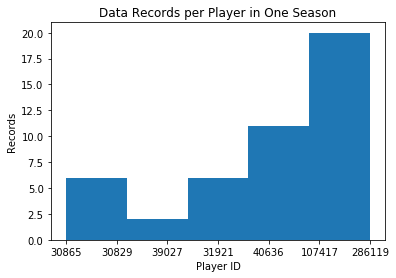

In [87]:
plt.hist(pl_best_players_attributes.player_api_id.astype('str'), bins = 5)
plt.title('Data Records per Player in One Season')
plt.xlabel('Player ID')
plt.ylabel('Records')
plt.show

The distribution shows the number of records/data points for the 'player of the season' in the season he won the award. From the distribution it becomes apperant that more information became available with time.
- This is because the Player IDs are sorted by year, thus, the Player IDs to the right of the graph are more recent.
- The bump in the beginning can be explain by the fact that the Player that is first in our dataset to win the award, did it twice => has more data records compared to the next winner.

#### 2.3.5 Attributes consolidation

What we can see from the previous distribution is that we have multiple data records for the same player across the year they won the aword. 
- __What?__ What we will attempt to do now is to consolidate all data points for each player.
- __How?__ We will do that by grouping the data by player ('player-api_id') and season ('season'). The addition of season is needed because there is one player that won twice.
- __Numerical/Categorical__ We will start with the numerical variables and then finish with the categorical.
- __Last__ We will remove the duplicates so that we are left one dimentional data points, rather than across time.

__Numerical__

Let's transform the numerical variables to their mean by player-season and save that in a variable that we will use later.

In [89]:
attributes_season_mean = pl_best_players_attributes.groupby(['player_api_id', 'season'])[['age', 'overall_rating', 'potential',
        'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
        'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
        'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
        'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
        'aggression', 'interceptions', 'positioning', 'vision', 'penalties']].transform('mean')

Now we will equate all features of the original datafame with what we got for mean.

In [90]:
pl_best_players_attributes[['age', 'overall_rating', 'potential',
        'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
        'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
        'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
        'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
        'aggression', 'interceptions', 'positioning', 'vision', 'penalties']] = attributes_season_mean[['age', 'overall_rating', 'potential',
        'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
        'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
        'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
        'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
        'aggression', 'interceptions', 'positioning', 'vision', 'penalties']]

C:\Users\satanasov\Anaconda3\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


We should see duplicating values for each player. One player should have multiple sets of duplicates. 

In [92]:
pl_best_players_attributes

,player_api_id,season,date,champion,attacking_work_rate,defensive_work_rate,age,overall_rating,potential,crossing,...,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties
0,30865,2008–9,2009-02-22,1,medium,high,26.500000,86.500000,89.000000,40.0,...,60.000000,92.0,80.5,92.000000,35.000000,93.0,82.5,86.000000,63.000000,79.000000
1,30865,2008–9,2008-08-30,1,medium,high,26.500000,86.500000,89.000000,40.0,...,60.000000,92.0,80.5,92.000000,35.000000,93.0,82.5,86.000000,63.000000,79.000000
2,30829,2009–10,2010-02-22,0,high,high,23.500000,88.000000,91.500000,80.5,...,91.500000,79.0,87.0,89.000000,87.000000,94.0,82.0,86.500000,88.000000,88.000000
3,30829,2009–10,2009-08-30,0,high,high,23.500000,88.000000,91.500000,80.5,...,91.500000,79.0,87.0,89.000000,87.000000,94.0,82.0,86.500000,88.000000,88.000000
4,30865,2010–11,2011-02-22,1,medium,high,28.500000,87.000000,90.000000,40.0,...,60.000000,92.0,69.0,92.000000,35.000000,92.0,84.0,47.000000,63.000000,62.000000
5,30865,2010–11,2010-08-30,1,medium,high,28.500000,87.000000,90.000000,40.0,...,60.000000,92.0,69.0,92.000000,35.000000,92.0,84.0,47.000000,63.000000,62.000000
6,39027,2011–12,2012-02-22,1,medium,high,25.000000,84.500000,88.500000,61.0,...,76.000000,70.5,70.0,88.000000,67.000000,75.0,87.0,41.000000,63.000000,63.000000
7,39027,2011–12,2011-08-30,1,medium,high,25.000000,84.500000,88.500000,61.0,...,76.000000,70.5,70.0,88.000000,67.000000,75.0,87.0,41.000000,63.000000,63.000000
8,31921,2012–13,2013-05-10,0,high,medium,23.000000,85.666667,90.833333,84.0,...,84.000000,68.0,90.0,77.833333,82.500000,77.0,67.5,82.166667,78.000000,74.500000
9,31921,2012–13,2013-04-12,0,high,medium,23.000000,85.666667,90.833333,84.0,...,84.000000,68.0,90.0,77.833333,82.500000,77.0,67.5,82.166667,78.000000,74.500000


__Categorical__

- `attacking_work_rate`
- `defensive_work_rate`

Let's see if the players changed either during the season

In [ ]:
pl_best_players_attributes.groupby(['player_api_id', 'attacking_work_rate']).groups

It appears that `attacking_work_rate` is consistent across the season for all players

Let's check that for the other categorical variable `defensive_work_rate`.

In [ ]:
pl_best_players_attributes.groupby(['player_api_id', 'defensive_work_rate']).groups

Same here, each `player_api_id` has only one category out of low/medium/high.

We can apply the present values for both `attacking_work_rate` and `defensive_work_rate` across each players.

__Last - Remove duplicates__

Now we can remove all duplicate rows and we will be left with unique player/season attributes data.

Would the `date` column be an issue since it is has unique values? Let's try, if yes, we will drop it as it is no longer needed anyway.

In [93]:
pl_best_players_attributes.drop_duplicates()

,player_api_id,season,date,champion,attacking_work_rate,defensive_work_rate,age,overall_rating,potential,crossing,...,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties
0,30865,2008–9,2009-02-22,1,medium,high,26.500000,86.500000,89.000000,40.0,...,60.000000,92.0,80.5,92.000000,35.000000,93.0,82.5,86.000000,63.000000,79.000000
1,30865,2008–9,2008-08-30,1,medium,high,26.500000,86.500000,89.000000,40.0,...,60.000000,92.0,80.5,92.000000,35.000000,93.0,82.5,86.000000,63.000000,79.000000
2,30829,2009–10,2010-02-22,0,high,high,23.500000,88.000000,91.500000,80.5,...,91.500000,79.0,87.0,89.000000,87.000000,94.0,82.0,86.500000,88.000000,88.000000
3,30829,2009–10,2009-08-30,0,high,high,23.500000,88.000000,91.500000,80.5,...,91.500000,79.0,87.0,89.000000,87.000000,94.0,82.0,86.500000,88.000000,88.000000
4,30865,2010–11,2011-02-22,1,medium,high,28.500000,87.000000,90.000000,40.0,...,60.000000,92.0,69.0,92.000000,35.000000,92.0,84.0,47.000000,63.000000,62.000000
5,30865,2010–11,2010-08-30,1,medium,high,28.500000,87.000000,90.000000,40.0,...,60.000000,92.0,69.0,92.000000,35.000000,92.0,84.0,47.000000,63.000000,62.000000
6,39027,2011–12,2012-02-22,1,medium,high,25.000000,84.500000,88.500000,61.0,...,76.000000,70.5,70.0,88.000000,67.000000,75.0,87.0,41.000000,63.000000,63.000000
7,39027,2011–12,2011-08-30,1,medium,high,25.000000,84.500000,88.500000,61.0,...,76.000000,70.5,70.0,88.000000,67.000000,75.0,87.0,41.000000,63.000000,63.000000
8,31921,2012–13,2013-05-10,0,high,medium,23.000000,85.666667,90.833333,84.0,...,84.000000,68.0,90.0,77.833333,82.500000,77.0,67.5,82.166667,78.000000,74.500000
9,31921,2012–13,2013-04-12,0,high,medium,23.000000,85.666667,90.833333,84.0,...,84.000000,68.0,90.0,77.833333,82.500000,77.0,67.5,82.166667,78.000000,74.500000


Nothing was dropped! Must be the `date` column. Let's test.

In [94]:
pl_best_players_attributes = pl_best_players_attributes.drop(columns = ['date'])
pl_best_players_attributes = pl_best_players_attributes.drop_duplicates()
#Voala?
pl_best_players_attributes

,player_api_id,season,champion,attacking_work_rate,defensive_work_rate,age,overall_rating,potential,crossing,finishing,...,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties
0,30865,2008–9,1,medium,high,26.500000,86.500000,89.000000,40.0,39.500000,...,60.000000,92.0,80.5,92.000000,35.000000,93.0,82.5,86.000000,63.000000,79.000000
2,30829,2009–10,0,high,high,23.500000,88.000000,91.500000,80.5,92.500000,...,91.500000,79.0,87.0,89.000000,87.000000,94.0,82.0,86.500000,88.000000,88.000000
4,30865,2010–11,1,medium,high,28.500000,87.000000,90.000000,40.0,41.000000,...,60.000000,92.0,69.0,92.000000,35.000000,92.0,84.0,47.000000,63.000000,62.000000
6,39027,2011–12,1,medium,high,25.000000,84.500000,88.500000,61.0,45.000000,...,76.000000,70.5,70.0,88.000000,67.000000,75.0,87.0,41.000000,63.000000,63.000000
8,31921,2012–13,0,high,medium,23.000000,85.666667,90.833333,84.0,82.666667,...,84.000000,68.0,90.0,77.833333,82.500000,77.0,67.5,82.166667,78.000000,74.500000
14,40636,2013–14,0,high,medium,26.454545,87.363636,87.636364,77.0,86.272727,...,82.636364,69.0,86.0,76.000000,82.454545,78.0,41.0,86.000000,82.363636,85.000000
25,107417,2014–15,1,high,medium,23.600000,88.000000,90.000000,78.0,83.000000,...,79.000000,59.0,74.0,63.000000,82.000000,54.0,41.0,84.000000,86.000000,86.000000
30,286119,2015–16,1,high,high,28.466667,74.866667,74.866667,61.8,77.000000,...,79.000000,66.4,90.0,68.466667,68.000000,88.4,51.0,76.866667,67.400000,71.733333


8 records for 8 seasons for 8 (actually 7) players.

Let's try putting this process into some sort of function, so that we can use it later if needed.

In [118]:
def consolidate(df):
    season_mean = df.groupby(['player_api_id', 'season'])[df.select_dtypes(include = 'number').columns[1:]].transform('mean')
    df[df.select_dtypes(include = 'number').columns[1:]] = season_mean
    df = df.drop(columns = ['date'])
    df = df.drop_duplicates()
    return df

## EDA <a class="anchor" id="eda-link"></a>